<a href="https://colab.research.google.com/github/no1rabbit/Cloud_chasing/blob/main/NDVI_jupyternotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

# Now import TensorFlow and it will use CPU
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

from math import cos
from tqdm import tqdm
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

# view all the entire dataset not truncated
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

2.15.0
[]
Mounted at /content/drive


In [4]:
!git clone https://github.com/no1rabbit/Cloud_chasing.git

Cloning into 'Cloud_chasing'...
remote: Enumerating objects: 130122, done.
remote: Counting objects: 100% (30741/30741), done.
remote: Compressing objects: 100% (22374/22374), done.
remote: Total 130122 (delta 7730), reused 30731 (delta 7726), pack-reused 99381
Receiving objects: 100% (130122/130122), 666.80 MiB | 27.55 MiB/s, done.
Resolving deltas: 100% (49971/49971), done.
Updating files: 100% (1419836/1419836), done.
Filtering content: 100% (115/115), 2.01 GiB | 185.47 MiB/s, done.


In [5]:
%cd "/content/Cloud_chasing"

/content/Cloud_chasing


In [10]:
# Import functions from the script file
from cloud_functions import rotate_image_and_heading, train_and_visualize

In [7]:
# Define paths to your data
gps_file = 'data/Serengeti_HMM.csv'

# Load GPS data
gps_data = pd.read_csv(gps_file)
gps_data = gps_data[gps_data['case_'] == True]
gps_data['sp_m'] = gps_data['species'] + '_' + gps_data['migrant'].astype(str)
gps_data = gps_data[gps_data['sp_m'] == 'WB_migrant']
gps_data['date1'] = pd.to_datetime(gps_data['date'])
gps_data['date'] = gps_data['date1'].dt.date
gps_data['month'] = gps_data['date1'].dt.month

gps_data = gps_data.sort_values(by=['ID','date'])

<ipython-input-7-3e9d074edcb5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gps_data['sp_m'] = gps_data['species'] + '_' + gps_data['migrant'].astype(str)


In [8]:
gps_data.head()

,ID,x1_,x2_,y1_,y2_,sl_,ta_,species,migrant,date,x,y,sex,dailystate,year,months,mon2,season,burst_,t1_,t2_,dt_,case_,step_id_,cos_ta_,log_sl_,sl_dist_shape,sl_dist_scale,ta_dist_kappa,ta_dist_mu,sp_m,date1,month
0,SW100,680764.8743,674933.7549,9724120.192,9728178.122,7104.136073,-0.431814,WB,migrant,2021-12-13,-2.497654,34.626559,F,migrating,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-13T07:30:00Z,2021-12-14T07:30:00Z,86400,True,3,0.908208,8.868432,0.810685,5075.168409,0.777039,0,WB_migrant,2021-12-13,12
11,SW100,674933.7549,675019.5210,9728178.122,9727439.122,743.960230,2.294312,WB,migrant,2021-12-14,-2.461019,34.574084,F,encamped,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-14T07:30:00Z,2021-12-15T07:30:00Z,86400,True,4,-0.662023,6.611988,0.810685,5075.168409,0.777039,0,WB_migrant,2021-12-14,12
22,SW100,675019.5210,673586.9019,9727439.122,9726742.822,1592.868851,-1.233925,WB,migrant,2021-12-15,-2.467701,34.574863,F,encamped,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-15T07:30:00Z,2021-12-16T07:30:00Z,86400,True,5,0.330536,7.373292,0.810685,5075.168409,0.777039,0,WB_migrant,2021-12-15,12
33,SW100,673586.9019,669799.8705,9726742.822,9723233.359,5163.132516,0.294964,WB,migrant,2021-12-16,-2.474014,34.561989,F,migrating,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-16T07:30:00Z,2021-12-17T07:30:00Z,86400,True,6,0.956813,8.549299,0.810685,5075.168409,0.777039,0,WB_migrant,2021-12-16,12
44,SW100,669799.8705,666982.3274,9723233.359,9716497.189,7301.680313,0.427264,WB,migrant,2021-12-17,-2.505793,34.527973,F,migrating,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-17T07:30:00Z,2021-12-18T07:30:00Z,86400,True,7,0.910103,8.895860,0.810685,5075.168409,0.777039,0,WB_migrant,2021-12-17,12


In [9]:
##
ds = xr.open_dataset('/content/drive/MyDrive/Cloud data/Serengeti_chirps_wide.nc')
#ds = xr.open_dataset('/content/drive/MyDrive/wildebeest_data/serengeti_modis_UTM_2015-2023.nc')
ds


<xarray.Dataset>
Dimensions:      (time: 3196, y: 144, x: 135)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01T11:59:59.500000 ... 2023-10...
  * y            (y) float64 1.01e+07 1.01e+07 1.009e+07 ... 9.392e+06 9.388e+06
  * x            (x) float64 3.725e+05 3.775e+05 ... 1.038e+06 1.042e+06
    spatial_ref  int32 ...
Data variables:
    rainfall     (time, y, x) float32 ...
Attributes:
    crs:           epsg:21036
    grid_mapping:  spatial_ref

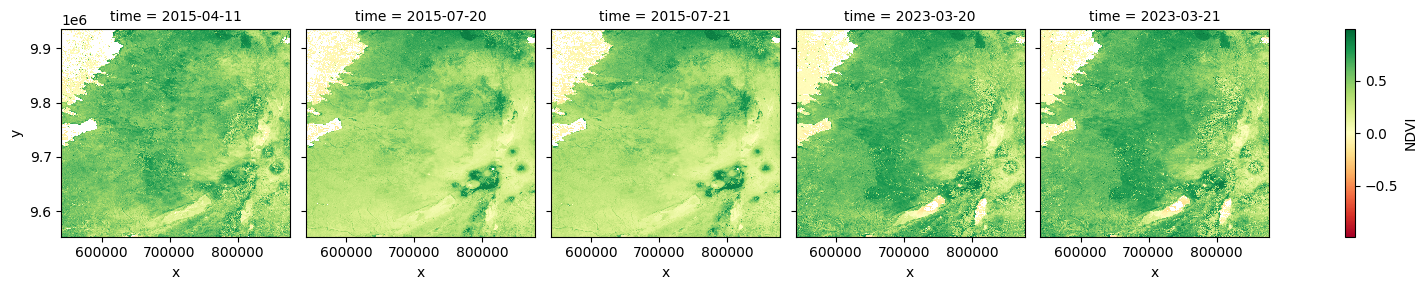

In [ ]:
ds.NDVI.isel(time = [100,200,201,3000,3001]).plot(col='time',col_wrap = 5, cmap='RdYlGn')

100%|██████████| 59/59 [02:38<00:00,  2.68s/it]


Epoch 1/100
50/50 [==============================] - 3s 27ms/step - loss: -0.0751 - val_loss: -0.1182
Epoch 2/100
50/50 [==============================] - 1s 21ms/step - loss: -0.1051 - val_loss: -0.1268
Epoch 3/100
50/50 [==============================] - 1s 21ms/step - loss: -0.1043 - val_loss: -0.1348
Epoch 4/100
50/50 [==============================] - 1s 20ms/step - loss: -0.1099 - val_loss: -0.1432
Epoch 5/100
50/50 [==============================] - 1s 20ms/step - loss: -0.1115 - val_loss: -0.1435
Epoch 6/100
50/50 [==============================] - 1s 20ms/step - loss: -0.1136 - val_loss: -0.1354
Epoch 7/100
50/50 [==============================] - 1s 20ms/step - loss: -0.1135 - val_loss: -0.1378
Epoch 8/100
50/50 [==============================] - 1s 20ms/step - loss: -0.1187 - val_loss: -0.1352
Epoch 9/100
50/50 [==============================] - 1s 24ms/step - loss: -0.1174 - val_loss: -0.1341
Epoch 10/100
50/50 [==============================] - 1s 26ms/step - loss: -0.1187

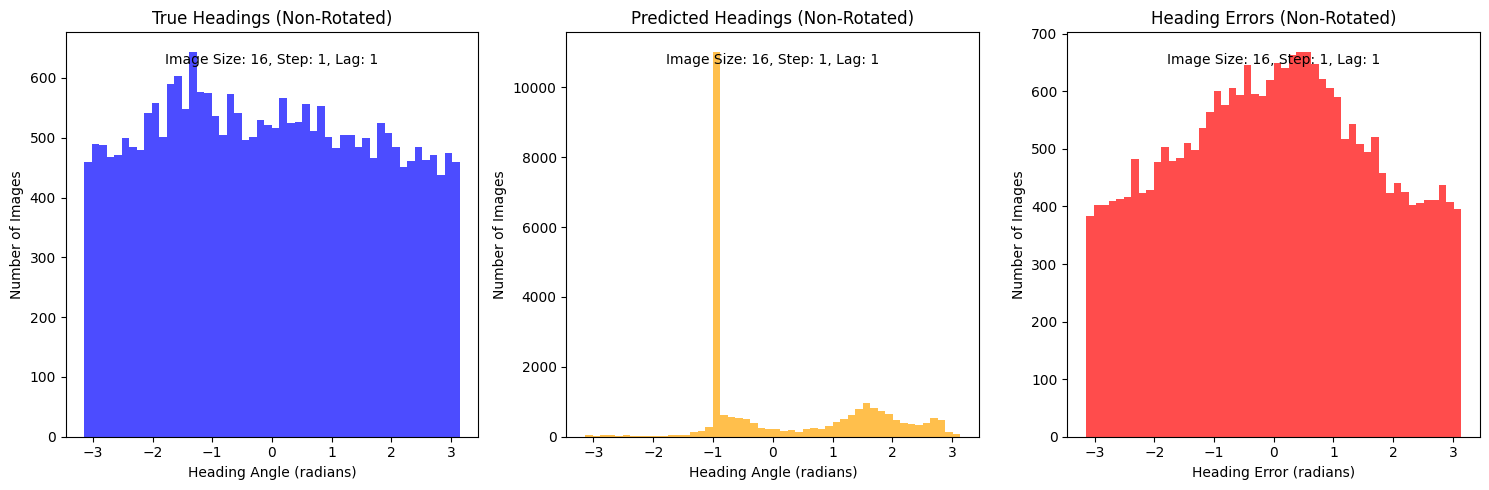

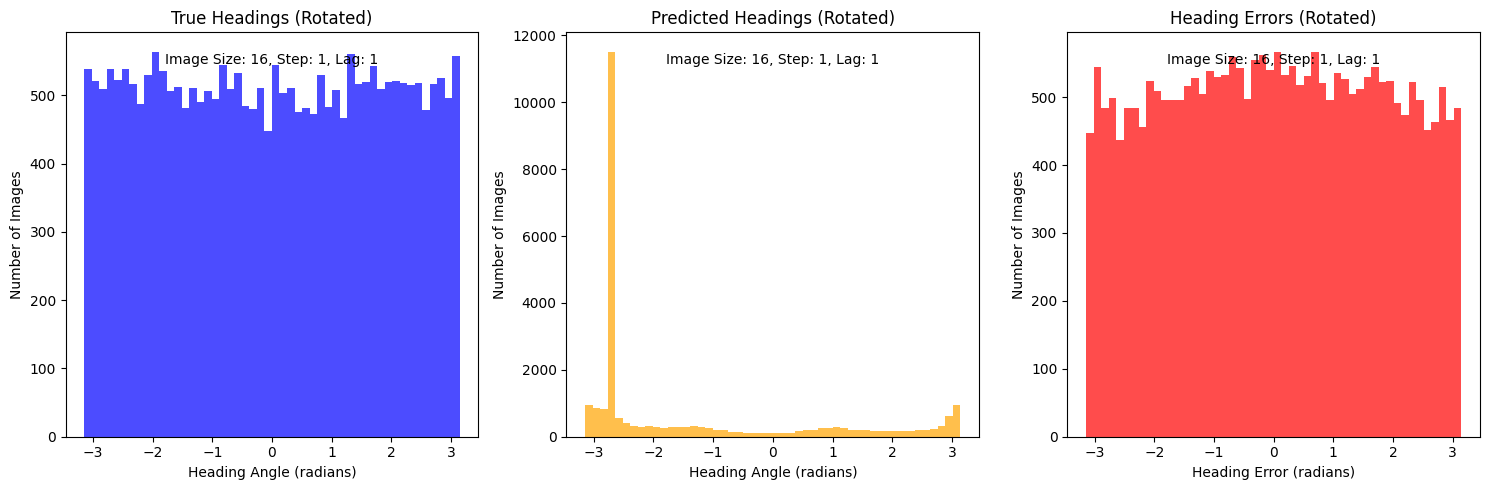

In [11]:
# Define lists of parameters to loop over
image_sizes = [16]#, 128, 256]
steps = [1]#, 3, 5, 7, 10]
lags = [1]#, 3, 5, 7, 10]

# Loop over parameter combinations
for image_size in image_sizes:
    for step in steps:
        for lag in lags:
            # Train and visualize results for non-rotated and rotated images
            results = train_and_visualize(gps_data, ds, 2018, image_size, step, lag)
            for result in results:
                label, true_angles, predicted_angles, heading_errors = result

                # Visualize results
                plt.figure(figsize=(15, 5))

                # Visualize true headings
                plt.subplot(1, 3, 1)
                plt.hist(true_angles, bins=50, color='blue', alpha=0.7)
                plt.title(f'True Headings ({label})')
                plt.xlabel('Heading Angle (radians)')
                plt.ylabel('Number of Images')
                plt.text(0.5, 0.95, f"Image Size: {image_size}, Step: {step}, Lag: {lag}",
                         horizontalalignment='center', verticalalignment='top', transform=plt.gca().transAxes)

                # Visualize predicted headings
                plt.subplot(1, 3, 2)
                plt.hist(predicted_angles, bins=50, color='orange', alpha=0.7)
                plt.title(f'Predicted Headings ({label})')
                plt.xlabel('Heading Angle (radians)')
                plt.ylabel('Number of Images')
                plt.text(0.5, 0.95, f"Image Size: {image_size}, Step: {step}, Lag: {lag}",
                         horizontalalignment='center', verticalalignment='top', transform=plt.gca().transAxes)

                # Visualize heading errors
                plt.subplot(1, 3, 3)
                plt.hist(heading_errors, bins=50, color='red', alpha=0.7)
                plt.title(f'Heading Errors ({label})')
                plt.xlabel('Heading Error (radians)')
                plt.ylabel('Number of Images')
                plt.text(0.5, 0.95, f"Image Size: {image_size}, Step: {step}, Lag: {lag}",
                         horizontalalignment='center', verticalalignment='top', transform=plt.gca().transAxes)

                plt.tight_layout()
                plt.show()

